# Self made SVD

In [1]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random

train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)

In [2]:
# Done similarly to https://github.com/albertauyeung/matrix-factorization-in-python
from tqdm import tqdm

class SVD():
    
    def __init__(self, train_ui, learning_rate, regularization, nb_factors, iterations):
        self.train_ui=train_ui
        self.uir=list(zip(*[train_ui.nonzero()[0],train_ui.nonzero()[1], train_ui.data]))
        
        self.learning_rate=learning_rate
        self.regularization=regularization
        self.iterations=iterations
        self.nb_users, self.nb_items=train_ui.shape
        self.nb_ratings=train_ui.nnz
        self.nb_factors=nb_factors
        
        self.Pu=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_users, self.nb_factors))
        self.Qi=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_items, self.nb_factors))

    def train(self, test_ui=None):
        if test_ui!=None:
            self.test_uir=list(zip(*[test_ui.nonzero()[0],test_ui.nonzero()[1], test_ui.data]))
            
        self.learning_process=[]
        pbar = tqdm(range(self.iterations))
        for i in pbar:
            pbar.set_description(f'Epoch {i} RMSE: {self.learning_process[-1][1] if i>0 else 0}. Training epoch {i+1}...')
            np.random.shuffle(self.uir)
            self.sgd(self.uir)
            if test_ui==None:
                self.learning_process.append([i+1, self.RMSE_total(self.uir)])
            else:
                self.learning_process.append([i+1, self.RMSE_total(self.uir), self.RMSE_total(self.test_uir)])
    
    def sgd(self, uir):
        
        for u, i, score in uir:
            # Computer prediction and error
            prediction = self.get_rating(u,i)
            e = (score - prediction)
            
            # Update user and item latent feature matrices
            Pu_update=self.learning_rate * (e * self.Qi[i] - self.regularization * self.Pu[u])
            Qi_update=self.learning_rate * (e * self.Pu[u] - self.regularization * self.Qi[i])
            
            self.Pu[u] += Pu_update
            self.Qi[i] += Qi_update
        
    def get_rating(self, u, i):
        prediction = self.Pu[u].dot(self.Qi[i].T)
        return prediction
    
    def RMSE_total(self, uir):
        RMSE=0
        for u,i, score in uir:
            prediction = self.get_rating(u,i)
            RMSE+=(score - prediction)**2
        return np.sqrt(RMSE/len(uir))
    
    def estimations(self):
        self.estimations=\
        np.dot(self.Pu,self.Qi.T)

    def recommend(self, user_code_id, item_code_id, topK=10):
        
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            
            user_rated=self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user+1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result=[]
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid]+list(chain(*item_scores[:topK])))
        return result
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result=[]
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user,item] if not np.isnan(self.estimations[user,item]) else 1])
        return result

In [3]:
model=SVD(train_ui, learning_rate=0.005, regularization=0.02, nb_factors=100, iterations=40)
model.train(test_ui)

Epoch 39 RMSE: 0.750963575605171. Training epoch 40...: 100%|██████████| 40/40 [01:38<00:00,  2.45s/it] 


In [4]:
import matplotlib.pyplot as plt

df=pd.DataFrame(model.learning_process).iloc[:,:2]
df.columns=['epoch', 'train_RMSE']
plt.plot('epoch', 'train_RMSE', data=df, color='blue')
plt.legend()

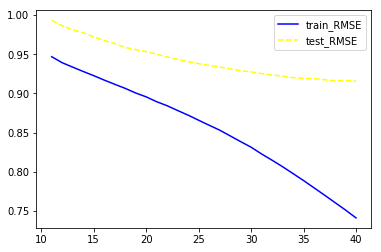

In [5]:
import matplotlib.pyplot as plt

df=pd.DataFrame(model.learning_process[10:], columns=['epoch', 'train_RMSE', 'test_RMSE'])
plt.plot('epoch', 'train_RMSE', data=df, color='blue')
plt.plot('epoch', 'test_RMSE', data=df, color='yellow', linestyle='dashed')
plt.legend()

#### Saving and evaluating recommendations

In [6]:
model.estimations()

top_n=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv('Recommendations generated/ml-100k/Self_SVD_reco.csv', index=False, header=False)

estimations=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_SVD_estimations.csv', index=False, header=False)

In [7]:
import evaluation_measures as ev

estimations_df=pd.read_csv('Recommendations generated/ml-100k/Self_SVD_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_SVD_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 7303.87it/s]


RMSE       MAE  precision    recall       F_1      F_05  \
0  0.91573  0.718921   0.102227  0.043137  0.051981  0.068872   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.093562      0.078057  0.104828  0.049448  0.191243  0.518286   

         HR       H2R  Reco in test  Test coverage  Shannon      Gini  
0  0.472959  0.258749      0.859279        0.13925  3.83152  0.973234

In [8]:
import evaluation_measures as ev

dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 6614.64it/s]
943it [00:00, 6657.91it/s]
943it [00:00, 6616.31it/s]
943it [00:00, 7049.97it/s]
943it [00:00, 7105.27it/s]
943it [00:00, 7296.68it/s]
943it [00:00, 6993.15it/s]
943it [00:00, 7255.64it/s]
943it [00:00, 6724.45it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0           Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0              Self_SVD  0.915730  0.718921   0.102227  0.043137  0.051981   
0        Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0        Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0          Ready_Random  1.524954  1.223352   0.045599  0.021181  0.024585   
0         Self_TopRated       NaN       NaN   0.032025  0.012674  0.015714   
0  Self_KNNSurprisetask  0.997106  0.784163   0.005620  0.002921  0.003494   
0       Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0             Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.068872         0.093562      0.078057  0.104828  0.049448  0.191243   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.031518         0.027897      0.021931  0.048111  0.017381  0.119005   
0  0.021183         0.028433      0.018573  0.022741  0.005328  0.031602   
0  0.004325         0.004936      0.003461  0.007103  0.002833  0.021431   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR       H2R  Reco in test  Test coverage   Shannon  \
0  0.555546  0.765642  0.492047      1.000000       0.038961  3.159079   
0  0.518286  0.472959  0.258749      0.859279       0.139250  3.831520   
0  0.515501  0.437964  0.239661      1.000000       0.033911  2.836513   
0  0.509546  0.384942  0.142100      1.000000       0.025974  2.711772   
0  0.507096  0.330859  0.091198      0.988123       0.181818  5.100792   
0  0.502764  0.237540  0.065748      0.697031       0.014430  2.220811   
0  0.497819  0.042418  0.009544      0.453234       0.137085  2.866347   
0  0.496424  0.009544  0.000000      0.600530       0.005051  1.803126   
0  0.496391  0.003181  0.000000      0.392153       0.115440  4.174741   

       Gini  
0  0.987317  
0  0.973234  
0  0.991139  
0  0.992003  
0  0.906866  
0  0.995173  
0  0.982811  
0  0.996380  
0  0.965327

### Embeddings

In [9]:
x=np.array([[1,2],[3,4]])
display(x)
x/np.linalg.norm(x, axis=1)[:,None]

array([[1, 2],
       [3, 4]])

array([[0.4472136 , 0.89442719],
       [0.6       , 0.8       ]])

In [10]:
item=random.choice(list(set(train_ui.indices)))

embeddings_norm=model.Qi/np.linalg.norm(model.Qi, axis=1)[:,None] # we do not mean-center here
# omitting normalization also makes sense, but items with a greater magnitude will be recommended more often

similarity_scores=np.dot(embeddings_norm,embeddings_norm[item].T)
top_similar_items=pd.DataFrame(enumerate(similarity_scores), columns=['code', 'score'])\
.sort_values(by=['score'], ascending=[False])[:10]

top_similar_items['item_id']=top_similar_items['code'].apply(lambda x: item_code_id[x])

items=pd.read_csv('./Datasets/ml-100k/movies.csv')

result=pd.merge(top_similar_items, items, left_on='item_id', right_on='id')

result

code     score  item_id    id  \
0  1455  1.000000     1456  1456   
1  1523  0.993083     1524  1524   
2  1366  0.992195     1367  1367   
3  1168  0.992131     1169  1169   
4  1368  0.991183     1369  1369   
5  1450  0.990743     1451  1451   
6   926  0.990661      927   927   
7  1067  0.990048     1068  1068   
8  1399  0.989842     1400  1400   
9  1204  0.989625     1205  1205   

                                               title          genres  
0                              Beat the Devil (1954)   Comedy, Drama  
1                               Kaspar Hauser (1993)           Drama  
2                                       Faust (1994)       Animation  
3                                       Fresh (1994)           Drama  
4  Forbidden Christ, The (Cristo proibito, Il) (1...           Drama  
5                       Foreign Correspondent (1940)        Thriller  
6  Flower of My Secret, The (Flor de mi secreto, ...           Drama  
7     Star Maker, The (Uomo delle stelle, L') (1995)           Drama  
8                               Picture Bride (1995)  Drama, Romance  
9                           Secret Agent, The (1996)           Drama

# project task 5:  implement SVD on top baseline (as it is in Surprise library)

In [11]:
# making changes to our implementation by considering additional parameters in the gradient descent procedure 
# seems to be the fastest option
# please save the output in 'Recommendations generated/ml-100k/Self_SVDBaseline_reco.csv' and
# 'Recommendations generated/ml-100k/Self_SVDBaseline_estimations.csv'

In [12]:
class SVD_bias():
    
    def __init__(self, train_ui, learning_rate, regularization, nb_factors, iterations):
        self.train_ui=train_ui
        self.uir=list(zip(*[train_ui.nonzero()[0],train_ui.nonzero()[1], train_ui.data]))
        
        self.learning_rate=learning_rate
        self.regularization=regularization
        self.iterations=iterations
        self.nb_users, self.nb_items=train_ui.shape
        self.nb_ratings=train_ui.nnz
        self.nb_factors=nb_factors
        
        self.Pu=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_users, self.nb_factors))
        self.Qi=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_items, self.nb_factors))
        self.bias_u = np.zeros(self.nb_users)
        self.bias_i = np.zeros(self.nb_items)

    def train(self, test_ui=None):
        if test_ui!=None:
            self.test_uir=list(zip(*[test_ui.nonzero()[0],test_ui.nonzero()[1], test_ui.data]))
            
        self.learning_process=[]
        pbar = tqdm(range(self.iterations))
        for i in pbar:
            pbar.set_description(f'Epoch {i} RMSE: {self.learning_process[-1][1] if i>0 else 0}. Training epoch {i+1}...')
            np.random.shuffle(self.uir)
            self.sgd(self.uir)
            if test_ui==None:
                self.learning_process.append([i+1, self.RMSE_total(self.uir)])
            else:
                self.learning_process.append([i+1, self.RMSE_total(self.uir), self.RMSE_total(self.test_uir)])
    
    def sgd(self, uir):
        
        for u, i, score in uir:
            # Computer prediction and error
            prediction = self.get_rating(u,i)
            e = (score - prediction)
            
            # Update user and item latent feature matrices
            Pu_update=self.learning_rate * (e * self.Qi[i] - self.regularization * self.Pu[u])
            Qi_update=self.learning_rate * (e * self.Pu[u] - self.regularization * self.Qi[i])
            bias_u_update=self.learning_rate * (e - self.regularization * self.bias_u[u])
            bias_i_update=self.learning_rate * (e - self.regularization * self.bias_i[i])
            
            self.Pu[u] += Pu_update
            self.Qi[i] += Qi_update
            self.bias_u[u] += bias_u_update
            self.bias_i[i] += bias_i_update
        
    def get_rating(self, u, i):
        prediction = self.bias_u[u] + self.bias_i[i] + self.Pu[u].dot(self.Qi[i].T)
        return prediction
    
    def RMSE_total(self, uir):
        RMSE=0
        for u,i, score in uir:
            prediction = self.get_rating(u,i)
            RMSE+=(score - prediction)**2
        return np.sqrt(RMSE/len(uir))
    
    def estimations(self):
        self.estimations=\
        self.bias_u[:,np.newaxis] + self.bias_i[np.newaxis:,] + np.dot(self.Pu,self.Qi.T)

    def recommend(self, user_code_id, item_code_id, topK=10):
        
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            
            user_rated=self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user+1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result=[]
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid]+list(chain(*item_scores[:topK])))
        return result
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result=[]
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user,item] if not np.isnan(self.estimations[user,item]) else 1])
        return result

# Ready-made SVD - Surprise implementation

### SVD

In [13]:
import helpers
import surprise as sp
import imp
imp.reload(helpers)

algo = sp.SVD(biased=False) # to use unbiased version

helpers.ready_made(algo, reco_path='Recommendations generated/ml-100k/Ready_SVD_reco.csv',
          estimations_path='Recommendations generated/ml-100k/Ready_SVD_estimations.csv')

Generating predictions...
Generating top N recommendations...
Generating predictions...


### SVD biased - on top baseline

In [14]:
import helpers
import surprise as sp
import imp
imp.reload(helpers)

algo = sp.SVD() # default is biased=True

helpers.ready_made(algo, reco_path='Recommendations generated/ml-100k/Ready_SVDBiased_reco.csv',
          estimations_path='Recommendations generated/ml-100k/Ready_SVDBiased_estimations.csv')

Generating predictions...
Generating top N recommendations...
Generating predictions...


In [15]:
import imp
imp.reload(ev)

import evaluation_measures as ev
dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 5926.84it/s]
943it [00:00, 6314.27it/s]
943it [00:00, 5917.48it/s]
943it [00:00, 6138.94it/s]
943it [00:00, 6278.83it/s]
943it [00:00, 6319.68it/s]
943it [00:00, 4892.96it/s]
943it [00:00, 6955.58it/s]
943it [00:00, 4946.53it/s]
943it [00:00, 6823.16it/s]
943it [00:00, 6276.95it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0           Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0             Ready_SVD  0.952247  0.751185   0.094168  0.044167  0.050919   
0              Self_SVD  0.915730  0.718921   0.102227  0.043137  0.051981   
0        Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0       Ready_SVDBiased  0.939053  0.740840   0.083881  0.034033  0.041862   
0        Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0          Ready_Random  1.524954  1.223352   0.045599  0.021181  0.024585   
0         Self_TopRated       NaN       NaN   0.032025  0.012674  0.015714   
0  Self_KNNSurprisetask  0.997106  0.784163   0.005620  0.002921  0.003494   
0       Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0             Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.065391         0.083047      0.069330  0.104266  0.047629  0.227719   
0  0.068872         0.093562      0.078057  0.104828  0.049448  0.191243   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.055808         0.074356      0.051753  0.092123  0.042224  0.199165   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.031518         0.027897      0.021931  0.048111  0.017381  0.119005   
0  0.021183         0.028433      0.018573  0.022741  0.005328  0.031602   
0  0.004325         0.004936      0.003461  0.007103  0.002833  0.021431   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR       H2R  Reco in test  Test coverage   Shannon  \
0  0.555546  0.765642  0.492047      1.000000       0.038961  3.159079   
0  0.518783  0.493107  0.238600      0.995016       0.212121  4.452947   
0  0.518286  0.472959  0.258749      0.859279       0.139250  3.831520   
0  0.515501  0.437964  0.239661      1.000000       0.033911  2.836513   
0  0.513679  0.434783  0.203606      0.996501       0.170274  4.190739   
0  0.509546  0.384942  0.142100      1.000000       0.025974  2.711772   
0  0.507096  0.330859  0.091198      0.988123       0.181818  5.100792   
0  0.502764  0.237540  0.065748      0.697031       0.014430  2.220811   
0  0.497819  0.042418  0.009544      0.453234       0.137085  2.866347   
0  0.496424  0.009544  0.000000      0.600530       0.005051  1.803126   
0  0.496391  0.003181  0.000000      0.392153       0.115440  4.174741   

       Gini  
0  0.987317  
0  0.951495  
0  0.973234  
0  0.991139  
0  0.963349  
0  0.992003  
0  0.906866  
0  0.995173  
0  0.982811  
0  0.996380  
0  0.965327